## San Diego COVID-19 History and Projections

For the past few weeks, the San Diego Regional Data Library has been scraping the offical COVID statistics from the County of San Diego. The data package is in the [Library's data repository](https://data.sandiegodata.org/dataset/sandiegodata-org-covid19-1-2-0/). Along with other data in the Library's collection, we now have neough observations to produce some estimates of the future growth of cases in the County 


In [1]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from sklearn import  linear_model
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import weibull_min, lognorm, logistic, norm
from scipy.optimize import curve_fit
from scipy.special import erf
from sklearn.metrics import r2_score

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [2]:
!env | grep CONDA

CONDA_SHLVL=2
CONDA_PROMPT_MODIFIER=(data) 
GSETTINGS_SCHEMA_DIR_CONDA_BACKUP=
CONDA_EXE=/Users/eric/opt/anaconda3/bin/conda
_CE_CONDA=
CONDA_PREFIX_1=/Users/eric/opt/anaconda3
CONDA_PREFIX=/Users/eric/opt/anaconda3/envs/data
CONDA_PYTHON_EXE=/Users/eric/opt/anaconda3/bin/python
CONDA_DEFAULT_ENV=data


In [3]:
!pip install pandas==0.24

In [4]:
import metapack as mp
pkg = mp.open_package('http://library.metatab.org/sandiegocounty.gov-covid19.csv')
pkg

# COVID 19 Statistics San Diego County
`sandiegocounty.gov-covid19-1.1.40` Last Update: 2020-08-14T18:09:29

_Official COVID-19 statistics for San Diego County._


## Documentation Links

* [Documentation Page](http://library.metatab.org/sandiegocounty.gov-covid19-1.1.40/index.html) 
* [Homepage](http://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-san-diego-county) One of the pages linking to COVID-19 data posted on arcgis.com

 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)
* **Origin** County of San Diego, Health and Human Services Agency, Public Health Services, Epidemiology and Immunization Services Branch

## Resources

* ** [covid_stats](http://library.metatab.org/sandiegocounty.gov-covid19-1.1.40/data/covid_stats.csv)**. COVID-19 cases in San Diego County, by sex and age
* ** [covid_jurisdiction](http://library.metatab.org/sandiegocounty.gov-covid19-1.1.40/data/covid_jurisdiction.csv)**. COVID-19 cases by San Diego jurisdiction
* ** [covid_jurisdiction_geo](http://library.metatab.org/sandiegocounty.gov-covid19-1.1.40/data/covid_jurisdiction_geo.csv)**. COVID-19 cases by San Diego jurisdiction, geographic
* ** [covid_zip](http://library.metatab.org/sandiegocounty.gov-covid19-1.1.40/data/covid_zip.csv)**. COVID-19 cases by zip code
* ** [covid_zip_geo](http://library.metatab.org/sandiegocounty.gov-covid19-1.1.40/data/covid_zip_geo.csv)**. COVID-19 cases by zip code, geographic

In [5]:
# Create Dataframes
covid_stats_df = pkg.resource('covid_stats').dataframe()
covid_jurisdiction_df = pkg.resource('covid_jurisdiction').dataframe()
#covid_jurisdiction_geo_gdf = pkg.resource('covid_jurisdiction_geo').geoframe()
covid_zip_df = pkg.resource('covid_zip').dataframe()
#covid_zip_geo_gdf = pkg.resource('covid_zip_geo').geoframe()


In [6]:
df = covid_stats_df[['date','tests','positives','hospitalized','icu','deaths']].sort_values('date')
df['date'] = pd.to_datetime(df.date)

df.columns = ['date', 'tests', 'cases', 'hosp','icu', 'deaths']
df['date'] = pd.to_datetime(df.date)
start_date = df.iloc[0].date
start_cases = df.iloc[0].cases
df['day'] = (df.date - start_date).dt.days

df['new_cases'] = df.cases.diff()
df['cases_rate'] = df.cases.diff().fillna(0)/ df.cases.shift(1)
df['cases_smooth'] = lowess(df.cases, df.day)[:,1]
df['cases_smooth_rate'] = df.cases_smooth.diff()/df.cases_smooth.shift(1)

df['new_hosp'] = df.hosp.diff()
df['hosp_rate'] = df.hosp.diff().fillna(0)/ df.hosp.shift(1)
df['hosp_smooth'] = lowess(df.hosp.fillna(0), df.day)[:,1]
df['hosp_smooth_rate'] = df.hosp.diff()/df.hosp_smooth.shift(1)

df['new_deaths'] = df.deaths.diff()
df['deaths_rate'] = df.deaths.diff().fillna(0)/ df.deaths.shift(1)
df['deaths_smooth'] = lowess(df.deaths.fillna(0), df.day)[:,1]
df['deaths_smooth_rate'] = df.deaths_smooth.diff()/df.deaths_smooth.shift(1)

df['new_tests'] = df.tests.diff()
df['tests_rate'] = df.tests.diff().fillna(0)/ df.tests.shift(1)
df['tests_smooth'] = lowess(df.tests.fillna(0), df.day)[:,1]
df['tests_smooth_rate'] = df.tests_smooth.diff()/df.tests_smooth.shift(1)

#df['double_days'] = np.log(2)/np.log(1+df.cases_smooth_rate)



In [7]:
# Fit functions. 
def func_norm(x, loc, scale, a):
    return a*norm.pdf(x,loc, scale)
func_norm.popt =  (22, 10, 3659)

def func_logpdf(x, loc, scale, a):
    return a*logistic.pdf(x,loc, scale)
func_logpdf.popt =  (22, 10, 3659)

def func_logistic(x, loc, scale, a): # popt = (14,4, 800)
    return a*logistic.cdf(x, loc, scale)
func_logistic.popt =  (14,4, 800)

def func_erf(x, loc, scale, a, b):
    return a*erf( (x-loc) / scale ) + b
func_erf.popt = (50,20,3000,3000)

def func_gomp(x, a, b, c):
    return a * np.exp(-b * np.exp(-c * x))
func_gomp.popt = (1000,10,.1)


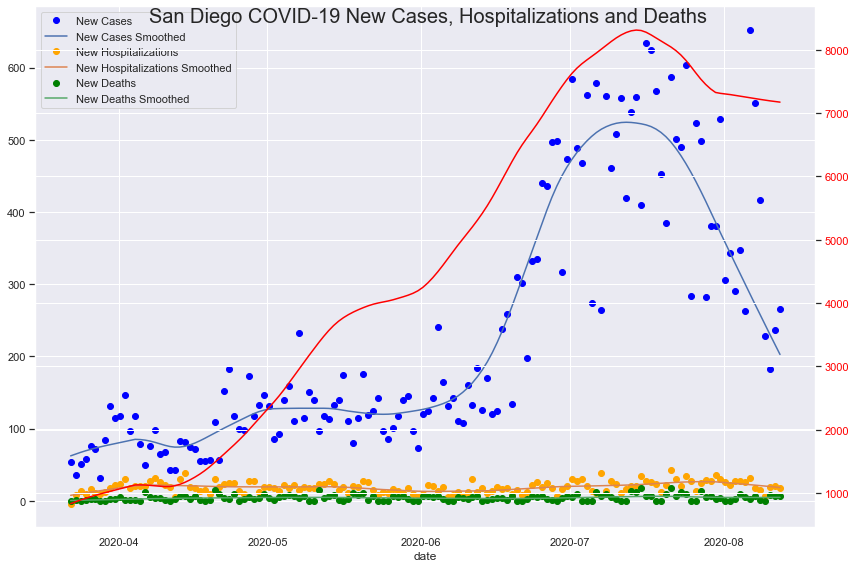

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("San Diego COVID-19 New Cases, Hospitalizations and Deaths", fontsize=20);

smoothing = 0.2

t = df.dropna(subset=['day','new_cases','new_hosp', 'new_tests', 'new_deaths']).copy()

t.new_hosp = t.new_hosp
t.new_cases = t.new_cases
t.new_deaths = t.new_deaths

ax.plot(t.date, t.new_cases, color='blue', label='New Cases', marker='o', linestyle='None')
smoothed = lowess(t.new_cases,  t.day,smoothing)
sns.lineplot(t.date, smoothed[:,1], label='New Cases Smoothed')

ax.plot(t.date, t.new_hosp, color='orange', label='New Hospitalizations', marker='o', linestyle='None')
smoothed = lowess(t.new_hosp,  t.day, smoothing)
sns.lineplot(t.date, smoothed[:,1], label='New Hospitalizations Smoothed')

ax.plot(t.date, t.new_deaths, color='green', label='New Deaths', marker='o', linestyle='None')
smoothed = lowess(t.new_deaths,  t.day, smoothing)
sns.lineplot(t.date, smoothed[:,1], label='New Deaths Smoothed')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

nt = t.new_tests 

#ax2.plot(t.date, nt, color='red', label='New Test', marker='o', linestyle='None')
smoothed = lowess(nt,  t.day, smoothing)
sns.lineplot(t.date[:len(smoothed[:,1])], smoothed[:,1], ax=ax2, color='red', linestyle='-')

ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


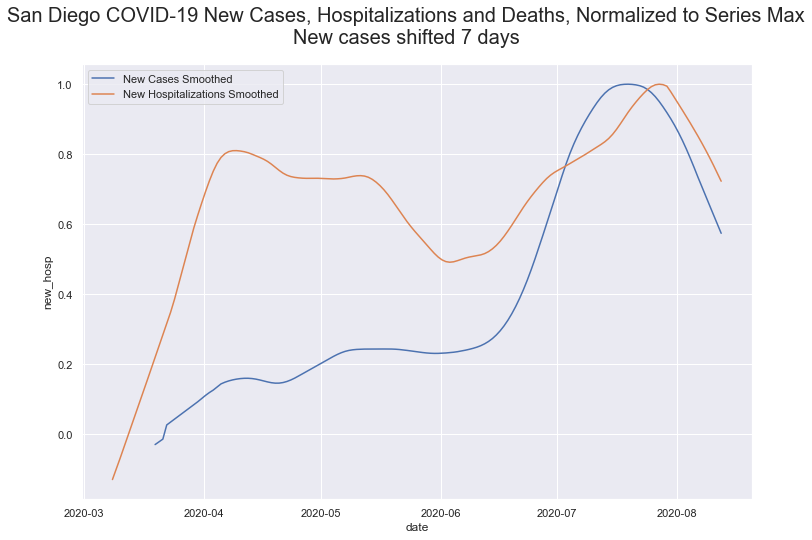

In [9]:
fig, ax = plt.subplots(figsize=(12,8))

smoothing = 0.2

t = df.dropna(subset=['day','new_cases','new_hosp']).copy()

t.new_cases = lowess(t.new_cases,  t.day,smoothing)[:,1]
t.new_cases = t.new_cases / t.new_cases.max()
#sns.lineplot(t.date, t.new_cases, label='New Cases Smoothed')

t.new_cases = t.new_cases.shift(7)
sns.lineplot(t.date, t.new_cases, label='New Cases Smoothed')

t.new_hosp = lowess(t.new_hosp,  t.day, smoothing)[:,1]
t.new_hosp = t.new_hosp / t.new_hosp.max()
sns.lineplot(t.date, t.new_hosp, label='New Hospitalizations Smoothed')


fig.suptitle("San Diego COVID-19 New Cases, Hospitalizations and Deaths, Normalized to Series Max\nNew cases shifted 7 days", fontsize=20);



0.04704551242048512


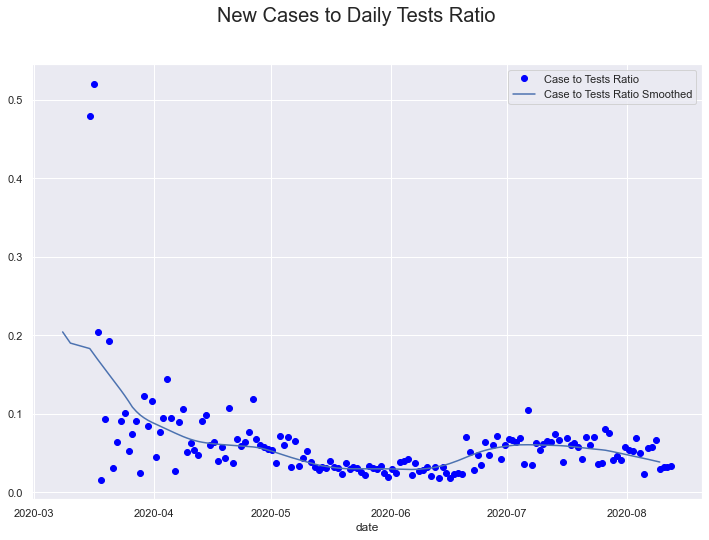

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("New Cases to Daily Tests Ratio", fontsize=20);
t = df.dropna(subset=['day','new_cases','new_hosp']).copy()
r = t.new_cases / t.new_tests

ax.plot(t.date, r, color='blue', label='Case to Tests Ratio', marker='o', linestyle='None')
smoothed = lowess(r,  t.day,smoothing)
sns.lineplot(t.date[:len(smoothed[:,1])], smoothed[:,1], label='Case to Tests Ratio Smoothed')
print(r.iloc[-14:].mean())

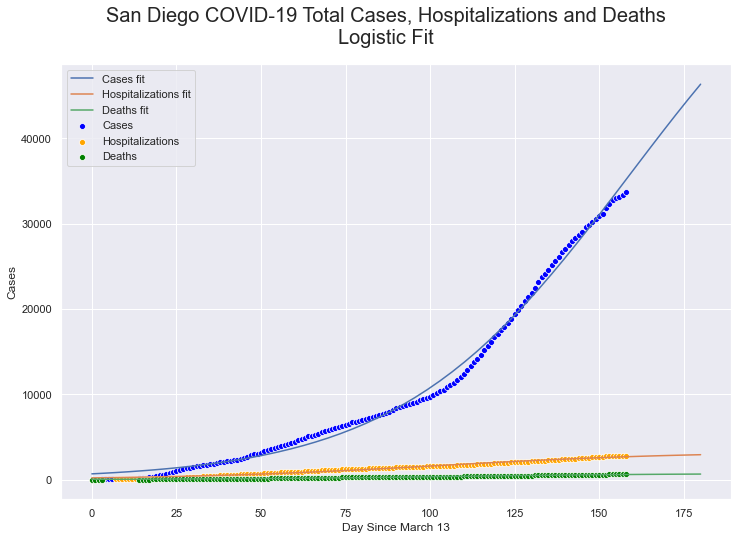

In [11]:


def tc_plot(ax, fit_func):

    t = df.dropna(subset=['day','cases','hosp', 'deaths']).copy()

    x = np.linspace(0,180)

    popt, pcov = curve_fit(fit_func, t.day, t.cases, p0=fit_func.popt, absolute_sigma = True)
    fitted = fit_func(x, *popt)
    sns.lineplot(x, fitted, label='Cases fit')
    sns.scatterplot(df.day, df.cases, ax=ax, color='blue', label='Cases')    
    #print(f"C Mean={round(popt[0])}, R^2={r2_score(df.cases, fitted[:len(df.cases)])}")

    popt, pcov = curve_fit(fit_func, t.day, t.hosp,popt, absolute_sigma = True)
    fitted = fit_func(x, *popt)
    sns.lineplot(x, fitted, label='Hospitalizations fit')
    sns.scatterplot(df.day, df.hosp,  ax=ax, color='orange', label='Hospitalizations')
    #print(f"H Mean={round(popt[0])}, R^2={r2_score(df.hosp.fillna(0), fitted[:len(df.hosp)])}")

    popt, pcov = curve_fit(fit_func, t.day, t.deaths,popt, absolute_sigma = True)
    fitted = fit_func(x, *popt)
    sns.lineplot(x, fitted, label='Deaths fit')
    #sns.lineplot(x=df.day, y=df.deaths_smooth, ax=ax, label='Deaths')   
    sns.scatterplot(t.day, t.deaths+1, ax=ax, color='green', label='Deaths')
    #print(f"D Mean={round(popt[0])}, R^2={r2_score(df.deaths.fillna(0), fitted[:len(df.deaths)])}")

    
fig, ax = plt.subplots(figsize=(12,8))   
tc_plot(ax, func_logistic)
ax.set_ylabel('Cases')
ax.set_xlabel('Day Since March 13')
fig.suptitle("San Diego COVID-19 Total Cases, Hospitalizations and Deaths\nLogistic Fit", fontsize=20);

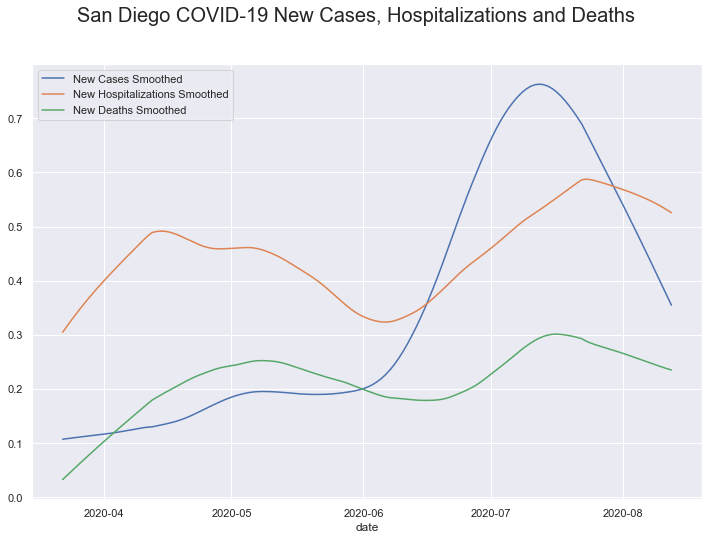

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("San Diego COVID-19 New Cases, Hospitalizations and Deaths", fontsize=20);

smoothing = 0.3

t = df.dropna(subset=['day','new_cases','new_hosp','new_tests', 'new_deaths']).copy()

t.new_hosp = t.new_hosp/np.max(t.new_hosp)
t.new_cases = t.new_cases/np.max(t.new_cases)
t.new_deaths = t.new_deaths/np.max(t.new_deaths)

smoothed = lowess(t.new_cases,  t.date,smoothing)
sns.lineplot(t.date, smoothed[:,1], label='New Cases Smoothed')
#sns.scatterplot(t.date, t.new_cases, ax=ax, color='blue', label='New Cases')

#sns.scatterplot(t.date, t.new_hosp, ax=ax, color='orange', label='New Hospitalizations')
smoothed = lowess(t.new_hosp,  t.date, smoothing)
sns.lineplot(t.date, smoothed[:,1], label='New Hospitalizations Smoothed')


#sns.scatterplot(t.date, t.new_deaths, ax=ax, color='green', label='New Deaths')
smoothed = lowess(t.new_deaths,  t.date, smoothing)
sns.lineplot(t.date, smoothed[:,1], label='New Deaths Smoothed')


In [13]:
t.date.describe()

count                     144
unique                    144
top       2020-03-23 08:00:00
freq                        1
first     2020-03-22 08:00:00
last      2020-08-12 08:00:00
Name: date, dtype: object

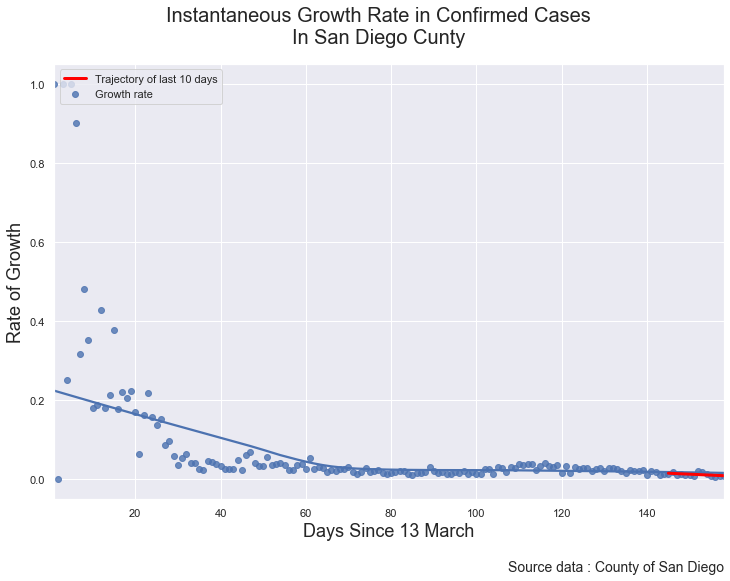

Coefficients: [[-0.00048152]] [0.08449039]
Zero growth at 175.4654434380813 days


In [14]:


def plot_gr(df, col):

    x = df.day.values.reshape(len(df), 1)[-14:]
    y = df[col].values.reshape(len(df), 1)[-14:]

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    fig, ax = plt.subplots(figsize=(12,8))
    fig.suptitle('Instantaneous Growth Rate in Confirmed Cases\nIn San Diego Cunty',fontsize=20)

    sns.regplot(ax=ax, x='day',y=col, data=df, lowess=True, label = 'Growth rate')

    ax.plot(x, regr.predict(x), color='red', linewidth=3, label = 'Trajectory of last 10 days')

    ax.set_xlabel('Days Since 13 March', fontsize=18)
    ax.set_ylabel('Rate of Growth', fontsize=18)

   
    plt.gcf().text(.65,0, f"Source data : County of San Diego", fontsize=14) 
    ax.legend(loc='upper left');
    plt.show()

    print('Coefficients:', regr.coef_, regr.intercept_)

    m = regr.coef_[0][0]
    b = regr.intercept_[0]

    
    print(f"Zero growth at {-b/m} days")

plot_gr(df.dropna(subset=['cases_rate']), 'cases_rate')
    

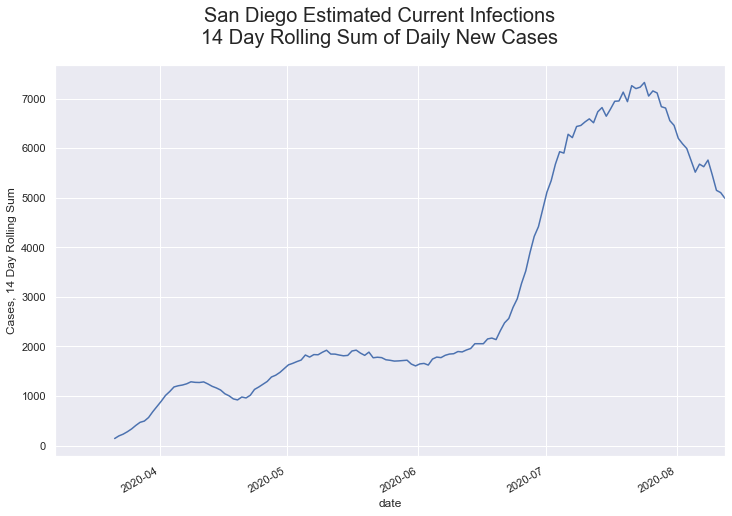

In [15]:
fig, ax = plt.subplots(figsize=(12,8))

fig.suptitle('San Diego Estimated Current Infections\n14 Day Rolling Sum of Daily New Cases',fontsize=20)

ax.set_ylabel('Cases, 14 Day Rolling Sum')
ax.set_xlabel('Date');

t = df.set_index('date')
t.new_cases.rolling(14).sum().plot()

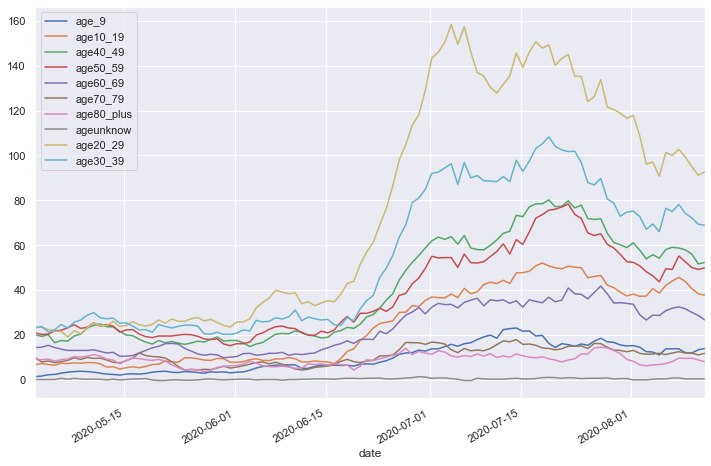

In [16]:
fig, ax = plt.subplots(figsize=(12,8))


stats = pkg.resource('covid_stats').dataframe()
stats['date'] = pd.to_datetime(df.date)
ages = stats[['date']+[c for c in stats.columns if 'age' in c]]
ages = ages.set_index('date').copy()

for c in ages.columns:
    ages[c] = ages[c].diff().rolling(7).mean()
    
t = ages.loc["2020-05-01":]

#t = t/t.iloc[0]

t.plot(ax=ax)